In [98]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [99]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [100]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [101]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

      unrate  psr       m2    dspic      pce    reer       

In [102]:
ticker='TSLA'

In [103]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [104]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [105]:
dates = pd.to_datetime(df['Date'])

In [106]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [107]:
df_for_training = df[cols].astype(float)

In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [109]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [110]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [111]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [112]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [113]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [114]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping


Epoch 1/100
6/6 [==============================] - 4s 93ms/step - loss: 0.0847 - val_loss: 0.0110
Epoch 2/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0093 - val_loss: 0.0140
Epoch 3/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0076 - val_loss: 0.0328
Epoch 4/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0106 - val_loss: 0.0206


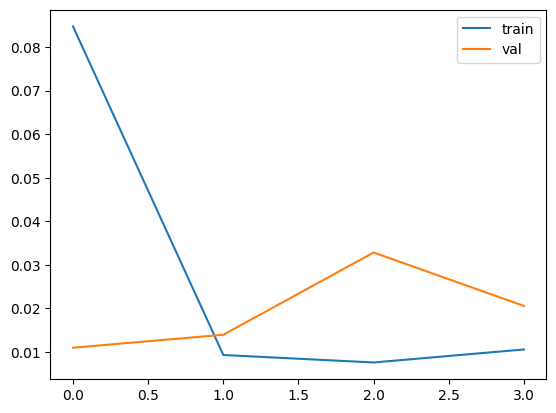

4/4 [==============================] - 0s 4ms/step
mae: 5.532409487324062


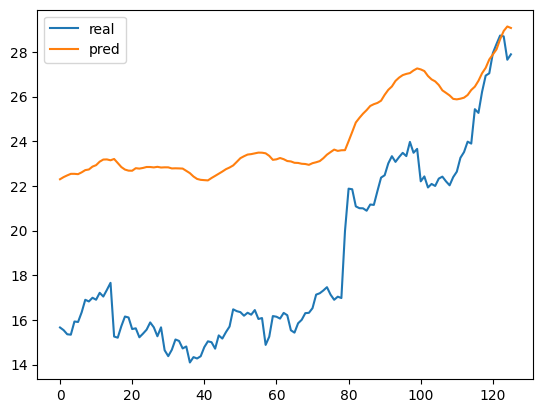

Epoch 1/100
12/12 [==============================] - 2s 42ms/step - loss: 0.0594 - val_loss: 0.0104
Epoch 2/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0120 - val_loss: 0.0253
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 7/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 10/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0031

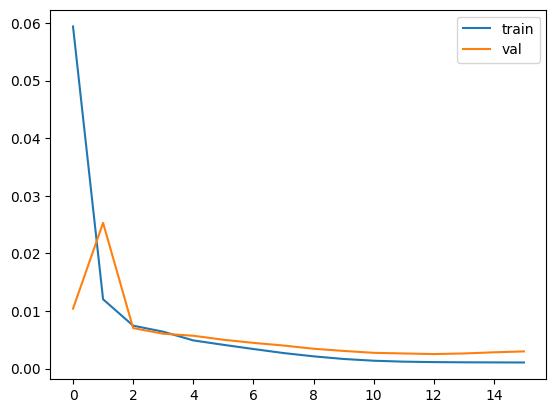

4/4 [==============================] - 0s 4ms/step
mae: 2.9251719234076607


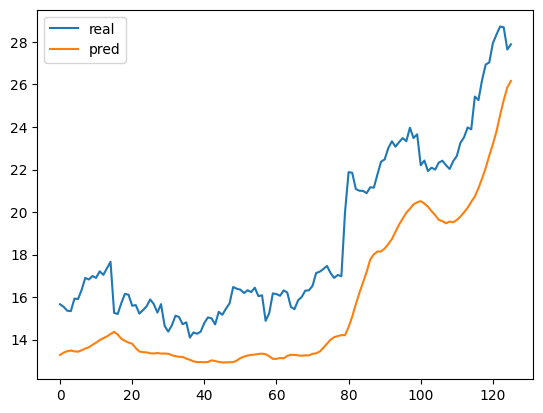

Epoch 1/100
18/18 [==============================] - 2s 25ms/step - loss: 0.0220 - val_loss: 0.1181
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0056 - val_loss: 0.0536
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0031 - val_loss: 0.0347
Epoch 4/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0024 - val_loss: 0.0120
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 6/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 7/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0029 - val_loss: 0.0324
Epoch 8/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0268


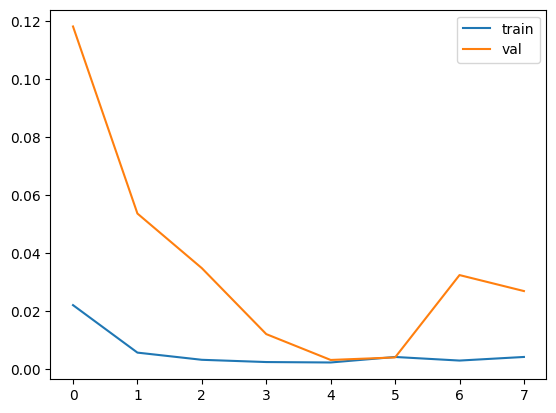

4/4 [==============================] - 0s 7ms/step
mae: 1.1764600228247266


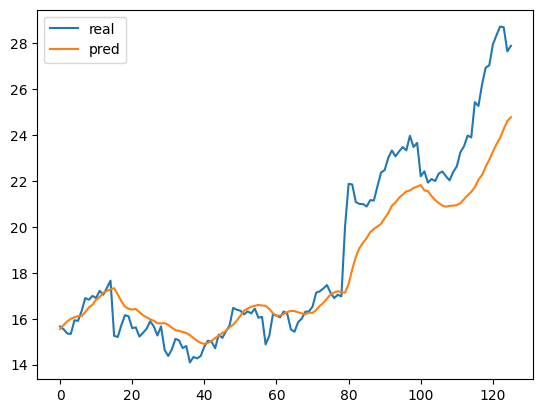

Epoch 1/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0127 - val_loss: 0.0814
Epoch 2/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0527 - val_loss: 0.0134
Epoch 3/100
24/24 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0360
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0286
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0068 - val_loss: 0.0552


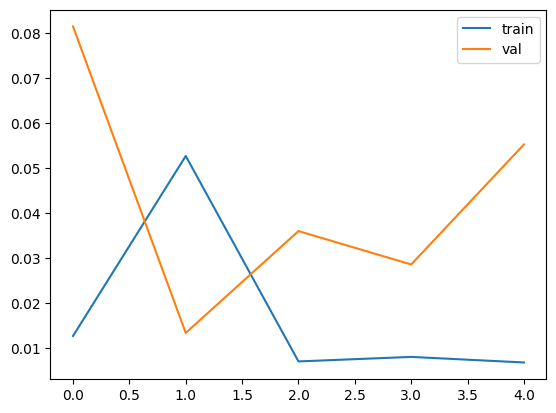

4/4 [==============================] - 0s 3ms/step
mae: 3.76317763390532


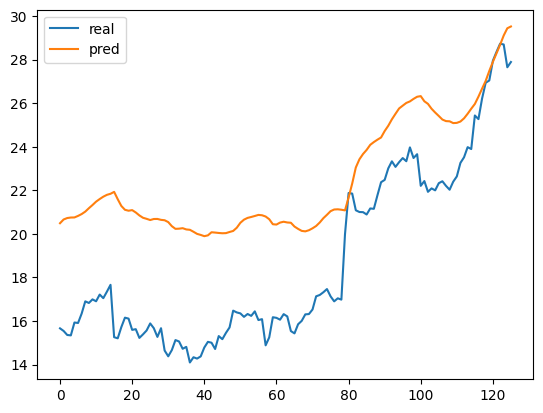

Epoch 1/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0164 - val_loss: 0.0067
Epoch 2/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0243 - val_loss: 0.0239
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 4/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 5/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0084


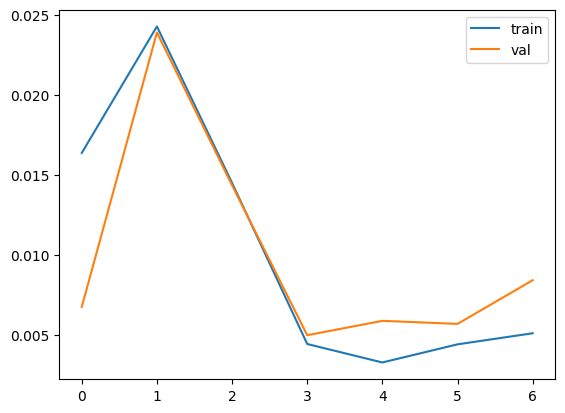

4/4 [==============================] - 0s 2ms/step
mae: 1.5023921152934727


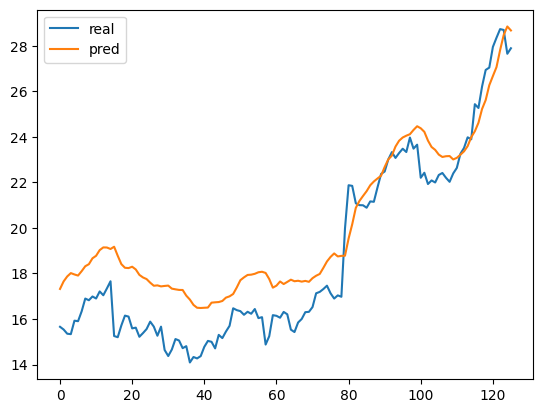

In [115]:
tscv = TimeSeriesSplit(n_splits=5)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=3)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(LSTM(64,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print('mae:',np.mean(np.abs(pred-y_test)))

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
